# BM25 (Best Matching 25) Model Implementation

This notebook implements a BM25 model following the requirements:
1. Introduction to BM25 model
2. Term selection methodology
3. Term weight calculation formula
4. Index creation
5. Query processing
6. Evaluation on Cranfield dataset using P, R and MAP metrics


In [17]:
# Import necessary libraries
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict, Counter
import ir_datasets
from itertools import islice
import math

# Additional imports for preprocessing and visualization
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import warnings
warnings.filterwarnings('ignore')

# BM25 implementation library
try:
    from rank_bm25 import BM25Okapi
    print("Using rank_bm25 library")
except ImportError:
    print("rank_bm25 not available, will implement BM25 manually")
    BM25Okapi = None

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Load Cranfield dataset using ir_datasets
dataset = ir_datasets.load("cranfield")

print("Libraries imported successfully!")
print("Cranfield dataset loaded!")


Using rank_bm25 library
Libraries imported successfully!
Cranfield dataset loaded!


## 1. Gi·ªõi thi·ªáu m√¥ h√¨nh BM25 (Best Matching 25)

**BM25 (Best Matching 25)** l√† m·ªôt h√†m x·∫øp h·∫°ng ƒë∆∞·ª£c s·ª≠ d·ª•ng r·ªông r√£i trong lƒ©nh v·ª±c truy xu·∫•t th√¥ng tin (Information Retrieval):

### Ph∆∞∆°ng ph√°p bi·ªÖu di·ªÖn t√†i li·ªáu v√† truy v·∫•n:
- **Probabilistic Model**: D·ª±a tr√™n m√¥ h√¨nh x√°c su·∫•t ƒë·ªÉ t√≠nh to√°n m·ª©c ƒë·ªô li√™n quan
- **Term Frequency**: Xem x√©t t·∫ßn su·∫•t xu·∫•t hi·ªán c·ªßa t·ª´ trong t√†i li·ªáu
- **Document Length Normalization**: Chu·∫©n h√≥a theo ƒë·ªô d√†i t√†i li·ªáu ƒë·ªÉ tr√°nh bias
- **Inverse Document Frequency**: T√≠nh tr·ªçng s·ªë d·ª±a tr√™n ƒë·ªô hi·∫øm c·ªßa t·ª´

### Nguy√™n t·∫Øc t√≠nh to√°n ƒë·ªô li√™n quan ƒë·ªÉ x·∫øp h·∫°ng:
1. **BM25 Score**: T√≠nh to√°n ƒëi·ªÉm s·ªë BM25 cho m·ªói c·∫∑p query-document
2. **Parameter Tuning**: S·ª≠ d·ª•ng c√°c tham s·ªë k1 (term frequency saturation) v√† b (length normalization)
3. **Ranking**: X·∫øp h·∫°ng t√†i li·ªáu theo ƒëi·ªÉm s·ªë BM25 t·ª´ cao xu·ªëng th·∫•p

### ∆Øu ƒëi·ªÉm c·ªßa BM25:
- Hi·ªáu qu·∫£ cao trong th·ª±c t·∫ø
- C√¢n b·∫±ng t·ªët gi·ªØa term frequency v√† document length
- ƒê∆∞·ª£c s·ª≠ d·ª•ng l√†m baseline trong nhi·ªÅu h·ªá th·ªëng t√¨m ki·∫øm
- D·ªÖ hi·ªÉu v√† tri·ªÉn khai


In [18]:
# Load Cranfield dataset using ir_datasets
documents = {}
queries = {}

# Load documents
for doc in dataset.docs_iter():
    documents[str(doc.doc_id)] = doc.text

# Load queries  
for query in dataset.queries_iter():
    queries[str(query.query_id)] = query.text

print(f"Loaded {len(documents)} documents")
print(f"Loaded {len(queries)} queries")
print("\nFirst few document IDs:", list(documents.keys())[:5])
print("\nFirst query:")
print(f"Query 1: {queries.get('1', 'Not found')}")
print("\nFirst document:")
print(f"Document 1: {documents.get('1', 'Not found')[:200]}...")


Loaded 1400 documents
Loaded 225 queries

First few document IDs: ['1', '2', '3', '4', '5']

First query:
Query 1: what similarity laws must be obeyed when constructing aeroelastic models
of heated high speed aircraft .

First document:
Document 1: experimental investigation of the aerodynamics of a
wing in a slipstream .
  an experimental study of a wing in a propeller slipstream was
made in order to determine the spanwise distribution of the l...


## 2. Ch·ªçn term: Ph∆∞∆°ng ph√°p x√°c ƒë·ªãnh v√† v√≠ d·ª• minh h·ªça

### Term ƒë∆∞·ª£c ch·ªçn l√† g√¨?
**Term** trong m√¥ h√¨nh BM25 l√† c√°c ƒë∆°n v·ªã t·ª´ v·ª±ng c∆° b·∫£n ƒë∆∞·ª£c s·ª≠ d·ª•ng ƒë·ªÉ bi·ªÉu di·ªÖn n·ªôi dung t√†i li·ªáu v√† truy v·∫•n.

### Ph∆∞∆°ng ph√°p x√°c ƒë·ªãnh term:

1. **Tokenization**: T√°ch vƒÉn b·∫£n th√†nh c√°c t·ª´ ri√™ng l·∫ª
2. **Lowercasing**: Chuy·ªÉn t·∫•t c·∫£ v·ªÅ ch·ªØ th∆∞·ªùng
3. **Stop word removal**: Lo·∫°i b·ªè c√°c t·ª´ kh√¥ng mang √Ω nghƒ©a (a, an, the, is, are...)
4. **Stemming/Lemmatization**: ƒê∆∞a v·ªÅ d·∫°ng g·ªëc c·ªßa t·ª´
5. **Filtering**: Lo·∫°i b·ªè t·ª´ qu√° ng·∫Øn, s·ªë, k√Ω t·ª± ƒë·∫∑c bi·ªát

### V√≠ d·ª• minh h·ªça qu√° tr√¨nh x√°c ƒë·ªãnh term:


In [19]:
# Text preprocessing function
def preprocess_text(text):
    """
    Preprocess text by tokenizing, removing stopwords, and stemming
    """
    # Initialize stemmer and stopwords
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    
    # Convert to lowercase and tokenize
    text = text.lower()
    tokens = word_tokenize(text)
    
    # Remove punctuation, numbers, and short words
    tokens = [token for token in tokens if token.isalpha() and len(token) > 2]
    
    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    
    # Stem words
    tokens = [stemmer.stem(token) for token in tokens]
    
    return tokens

# Example demonstration of term selection process
sample_text = "experimental investigation of the aerodynamics of a wing in a slipstream"
print("Original text:")
print(f"'{sample_text}'")
print("\nStep-by-step term extraction process:")

# Step 1: Tokenization and lowercasing
tokens = word_tokenize(sample_text.lower())
print(f"1. Tokenization: {tokens}")

# Step 2: Remove punctuation and short words
filtered_tokens = [token for token in tokens if token.isalpha() and len(token) > 2]
print(f"2. Filter alpha and length > 2: {filtered_tokens}")

# Step 3: Remove stopwords
stop_words = set(stopwords.words('english'))
no_stopwords = [token for token in filtered_tokens if token not in stop_words]
print(f"3. Remove stopwords: {no_stopwords}")

# Step 4: Stemming
stemmer = PorterStemmer()
stemmed = [stemmer.stem(token) for token in no_stopwords]
print(f"4. Stemming: {stemmed}")

print(f"\nFinal terms: {stemmed}")
print(f"Number of terms: {len(stemmed)}")

# Process all documents to extract terms
print("\nProcessing all documents...")
processed_docs = {}
all_terms = set()

for doc_id, content in list(documents.items())[:5]:  # Process first 5 for demonstration
    terms = preprocess_text(content)
    processed_docs[doc_id] = terms
    all_terms.update(terms)

print(f"\nExample processed documents (first 5):")
for doc_id, terms in list(processed_docs.items())[:3]:
    print(f"Document {doc_id}: {terms[:10]}...")  # Show first 10 terms

print(f"\nTotal unique terms from first 5 documents: {len(all_terms)}")
print(f"Sample terms: {list(all_terms)[:20]}")


Original text:
'experimental investigation of the aerodynamics of a wing in a slipstream'

Step-by-step term extraction process:
1. Tokenization: ['experimental', 'investigation', 'of', 'the', 'aerodynamics', 'of', 'a', 'wing', 'in', 'a', 'slipstream']
2. Filter alpha and length > 2: ['experimental', 'investigation', 'the', 'aerodynamics', 'wing', 'slipstream']
3. Remove stopwords: ['experimental', 'investigation', 'aerodynamics', 'wing', 'slipstream']
4. Stemming: ['experiment', 'investig', 'aerodynam', 'wing', 'slipstream']

Final terms: ['experiment', 'investig', 'aerodynam', 'wing', 'slipstream']
Number of terms: 5

Processing all documents...

Example processed documents (first 5):
Document 1: ['experiment', 'investig', 'aerodynam', 'wing', 'slipstream', 'experiment', 'studi', 'wing', 'propel', 'slipstream']...
Document 2: ['simpl', 'shear', 'flow', 'past', 'flat', 'plate', 'incompress', 'fluid', 'small', 'viscos']...
Document 3: ['boundari', 'layer', 'simpl', 'shear', 'flow', 'pa

## 3. C√¥ng th·ª©c t√≠nh tr·ªçng s·ªë term: BM25

### C√¥ng th·ª©c BM25:
BM25 t√≠nh ƒëi·ªÉm s·ªë cho m·ªói term trong query d·ª±a tr√™n c√¥ng th·ª©c:

**BM25(q,d) = Œ£ IDF(qi) √ó f(qi,d) √ó (k1 + 1) / (f(qi,d) + k1 √ó (1 - b + b √ó |d|/avgdl))**

### C√°c th√†nh ph·∫ßn c·ªßa c√¥ng th·ª©c:

1. **IDF (Inverse Document Frequency)**:
   - IDF(qi) = log((N - df(qi) + 0.5) / (df(qi) + 0.5))
   - N = T·ªïng s·ªë documents
   - df(qi) = S·ªë documents ch·ª©a term qi

2. **Term Frequency (f(qi,d))**:
   - S·ªë l·∫ßn term qi xu·∫•t hi·ªán trong document d

3. **Document Length Normalization**:
   - |d| = ƒê·ªô d√†i c·ªßa document d
   - avgdl = ƒê·ªô d√†i trung b√¨nh c·ªßa t·∫•t c·∫£ documents

4. **Tham s·ªë ƒëi·ªÅu ch·ªânh**:
   - **k1**: ƒêi·ªÅu ch·ªânh t·∫ßn su·∫•t term (th∆∞·ªùng 1.2-2.0)
   - **b**: ƒêi·ªÅu ch·ªânh ƒë·ªô d√†i document (th∆∞·ªùng 0.75)

### √ù nghƒ©a:
- **Saturation**: Term frequency kh√¥ng tƒÉng v√¥ h·∫°n (do k1)
- **Length Normalization**: Document d√†i kh√¥ng ƒë∆∞·ª£c ∆∞u ti√™n qu√° m·ª©c (do b)
- **IDF weighting**: Terms hi·∫øm c√≥ tr·ªçng s·ªë cao h∆°n


In [20]:
# BM25 Implementation
class BM25:
    def __init__(self, k1=1.5, b=0.75):
        self.k1 = k1
        self.b = b
        self.corpus = None
        self.doc_freqs = None
        self.idf = None
        self.doc_lens = None
        self.avgdl = None
        self.N = None
        
    def fit(self, corpus):
        """
        Fit BM25 model on corpus
        corpus: list of tokenized documents
        """
        self.corpus = corpus
        self.N = len(corpus)
        
        # Calculate document lengths
        self.doc_lens = [len(doc) for doc in corpus]
        self.avgdl = sum(self.doc_lens) / self.N
        
        # Calculate document frequencies
        self.doc_freqs = []
        vocabulary = set()
        
        for doc in corpus:
            freq = Counter(doc)
            self.doc_freqs.append(freq)
            vocabulary.update(freq.keys())
        
        # Calculate IDF values
        self.idf = {}
        for term in vocabulary:
            df = sum(1 for doc_freq in self.doc_freqs if term in doc_freq)
            idf_value = math.log((self.N - df + 0.5) / (df + 0.5))
            self.idf[term] = idf_value
            
        return self
    
    def get_scores(self, query):
        """
        Calculate BM25 scores for query against all documents
        """
        scores = np.zeros(self.N)
        
        for i, doc_freq in enumerate(self.doc_freqs):
            score = 0
            doc_len = self.doc_lens[i]
            
            for term in query:
                if term in self.idf:
                    freq = doc_freq.get(term, 0)
                    idf = self.idf[term]
                    
                    # BM25 formula
                    numerator = freq * (self.k1 + 1)
                    denominator = freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl)
                    score += idf * (numerator / denominator)
            
            scores[i] = score
            
        return scores

# Preprocess all documents for BM25
print("Preprocessing documents for BM25...")
doc_list = list(documents.values())
doc_ids = list(documents.keys())

# Preprocess documents
processed_corpus = []
for doc in doc_list:
    terms = preprocess_text(doc)
    processed_corpus.append(terms)

print(f"Processed {len(processed_corpus)} documents")

# Initialize and fit BM25 model
print("Training BM25 model...")
bm25_model = BM25(k1=1.5, b=0.75)
bm25_model.fit(processed_corpus)

print(f"BM25 model trained successfully!")
print(f"Vocabulary size: {len(bm25_model.idf)}")
print(f"Average document length: {bm25_model.avgdl:.2f}")

# Example calculation
print("\n=== Manual BM25 Calculation Example ===")
sample_query = ["wing", "aerodynam", "flow"]
sample_doc_idx = 0

print(f"Query terms: {sample_query}")
print(f"Document {doc_ids[sample_doc_idx]} terms: {processed_corpus[sample_doc_idx][:10]}...")

# Calculate BM25 score manually for demonstration
doc_freq = bm25_model.doc_freqs[sample_doc_idx]
doc_len = bm25_model.doc_lens[sample_doc_idx]
total_score = 0

print(f"\nBM25 calculation details:")
for term in sample_query:
    if term in bm25_model.idf:
        freq = doc_freq.get(term, 0)
        idf = bm25_model.idf[term]
        
        numerator = freq * (bm25_model.k1 + 1)
        denominator = freq + bm25_model.k1 * (1 - bm25_model.b + bm25_model.b * doc_len / bm25_model.avgdl)
        term_score = idf * (numerator / denominator)
        total_score += term_score
        
        print(f"Term '{term}':")
        print(f"  Frequency in doc: {freq}")
        print(f"  IDF: {idf:.4f}")
        print(f"  Term score: {term_score:.4f}")

print(f"\nTotal BM25 score: {total_score:.4f}")

# Verify with model calculation
model_scores = bm25_model.get_scores(sample_query)
print(f"Model calculated score: {model_scores[sample_doc_idx]:.4f}")
print(f"Difference: {abs(total_score - model_scores[sample_doc_idx]):.6f}")


Preprocessing documents for BM25...
Processed 1400 documents
Training BM25 model...
BM25 model trained successfully!
Vocabulary size: 4049
Average document length: 84.45

=== Manual BM25 Calculation Example ===
Query terms: ['wing', 'aerodynam', 'flow']
Document 1 terms: ['experiment', 'investig', 'aerodynam', 'wing', 'slipstream', 'experiment', 'studi', 'wing', 'propel', 'slipstream']...

BM25 calculation details:
Term 'wing':
  Frequency in doc: 3
  IDF: 1.6995
  Term score: 2.9140
Term 'aerodynam':
  Frequency in doc: 1
  IDF: 1.9500
  Term score: 2.0534
Term 'flow':
  Frequency in doc: 1
  IDF: -0.0371
  Term score: -0.0391

Total BM25 score: 4.9283
Model calculated score: 4.9283
Difference: 0.000000


## 4. T·∫°o ch·ªâ m·ª•c (Index Creation)

### C·∫•u tr√∫c ch·ªâ m·ª•c BM25:
1. **Document Frequencies**: T·∫ßn su·∫•t t·ª´ trong m·ªói t√†i li·ªáu
2. **IDF Dictionary**: Gi√° tr·ªã IDF cho m·ªói term
3. **Document Lengths**: ƒê·ªô d√†i c·ªßa m·ªói t√†i li·ªáu
4. **Average Document Length**: ƒê·ªô d√†i trung b√¨nh c·ªßa corpus

### Quy tr√¨nh t·∫°o ch·ªâ m·ª•c:
1. Ti·ªÅn x·ª≠ l√Ω t·∫•t c·∫£ t√†i li·ªáu
2. T√≠nh to√°n document frequencies cho m·ªói t√†i li·ªáu
3. T√≠nh to√°n IDF cho m·ªói term
4. L∆∞u tr·ªØ metadata (document lengths, average length)


In [21]:
# CHI TI·∫æT QUY TR√åNH T·∫†O CH·ªà M·ª§C BM25 THEO 4 B∆Ø·ªöC
print("=" * 80)
print("QUY TR√åNH T·∫†O CH·ªà M·ª§C BM25 - CHI TI·∫æT T·ª™NG B∆Ø·ªöC")
print("=" * 80)

# L·∫•y sample nh·ªè ƒë·ªÉ demo chi ti·∫øt (3 documents ƒë·∫ßu ti√™n)
sample_docs = {
    "1": documents["1"][:200],  # R√∫t ng·∫Øn ƒë·ªÉ d·ªÖ theo d√µi
    "2": documents["2"][:200],
    "3": documents["3"][:200]
}

print(f"DEMO v·ªõi {len(sample_docs)} documents m·∫´u:")
for doc_id, content in sample_docs.items():
    print(f"\nDoc {doc_id}: {content}")

print("\n" + "=" * 80)
print("B∆Ø·ªöC 1: TI·ªÄN X·ª¨ L√ù T·∫§T C·∫¢ T√ÄI LI·ªÜU")
print("=" * 80)

print("INPUT: Raw documents text")
print("PROCESSING: Tokenization ‚Üí Lowercasing ‚Üí Stop word removal ‚Üí Stemming")
print("OUTPUT: Processed document terms")

# Ti·ªÅn x·ª≠ l√Ω documents
processed_documents = {}
all_original_lengths = {}
all_processed_lengths = {}

print(f"\nCHI TI·∫æT TI·ªÄN X·ª¨ L√ù:")
print("-" * 60)

for doc_id, raw_text in sample_docs.items():
    print(f"\nDocument {doc_id}:")
    print(f"  Raw text: '{raw_text[:100]}...'")
    print(f"  Raw length: {len(raw_text)} characters")
    
    # B∆∞·ªõc 1: Tokenization
    tokens = word_tokenize(raw_text.lower())
    print(f"  After tokenization: {tokens[:10]}... ({len(tokens)} tokens)")
    
    # B∆∞·ªõc 2: Remove punctuation v√† short words
    alpha_tokens = [token for token in tokens if token.isalpha() and len(token) > 2]
    print(f"  After filtering: {alpha_tokens[:10]}... ({len(alpha_tokens)} tokens)")
    
    # B∆∞·ªõc 3: Remove stopwords
    stop_words = set(stopwords.words('english'))
    no_stopwords = [token for token in alpha_tokens if token not in stop_words]
    print(f"  After stopword removal: {no_stopwords[:10]}... ({len(no_stopwords)} tokens)")
    
    # B∆∞·ªõc 4: Stemming
    stemmer = PorterStemmer()
    stemmed_terms = [stemmer.stem(token) for token in no_stopwords]
    print(f"  Final processed terms: {stemmed_terms[:10]}... ({len(stemmed_terms)} terms)")
    
    # L∆∞u tr·ªØ k·∫øt qu·∫£
    processed_documents[doc_id] = stemmed_terms
    all_original_lengths[doc_id] = len(tokens)
    all_processed_lengths[doc_id] = len(stemmed_terms)
    
    print(f"  Reduction ratio: {len(stemmed_terms)/len(tokens):.3f}")

# T·ªïng h·ª£p k·∫øt qu·∫£ b∆∞·ªõc 1
print(f"\nT·ªîNG H·ª¢P B∆Ø·ªöC 1:")
print(f"  Documents processed: {len(processed_documents)}")
print(f"  Average original length: {np.mean(list(all_original_lengths.values())):.1f} tokens")
print(f"  Average processed length: {np.mean(list(all_processed_lengths.values())):.1f} terms")

# Thu th·∫≠p t·∫•t c·∫£ unique terms
all_terms = set()
for terms in processed_documents.values():
    all_terms.update(terms)

print(f"  Total unique terms in vocabulary: {len(all_terms)}")
print(f"  Sample vocabulary: {sorted(list(all_terms))[:15]}")

print("\n" + "=" * 80)
print("B∆Ø·ªöC 2: T√çNH TO√ÅN DOCUMENT FREQUENCIES CHO M·ªñI T√ÄI LI·ªÜU")
print("=" * 80)

print("INPUT: Processed document terms")
print("PROCESSING: Count term frequencies in each document")
print("OUTPUT: Term frequency dictionaries for each document")

document_term_frequencies = {}
document_lengths = {}

print(f"\nCHI TI·∫æT T√çNH TERM FREQUENCIES:")
print("-" * 60)

for doc_id, terms in processed_documents.items():
    print(f"\nDocument {doc_id}:")
    print(f"  Terms: {terms}")
    print(f"  Document length: {len(terms)} terms")
    
    # T√≠nh term frequency cho document n√†y
    tf_dict = {}
    for term in terms:
        tf_dict[term] = tf_dict.get(term, 0) + 1
    
    # S·∫Øp x·∫øp theo frequency gi·∫£m d·∫ßn
    sorted_tf = sorted(tf_dict.items(), key=lambda x: x[1], reverse=True)
    
    print(f"  Unique terms: {len(tf_dict)}")
    print(f"  Term frequencies (top 10):")
    for term, freq in sorted_tf[:10]:
        print(f"    '{term}': {freq}")
    
    # Hi·ªÉn th·ªã TF normalization (TF / doc_length)
    print(f"  Normalized TF (TF/doc_length, top 5):")
    for term, freq in sorted_tf[:5]:
        normalized_tf = freq / len(terms)
        print(f"    '{term}': {freq}/{len(terms)} = {normalized_tf:.4f}")
    
    # L∆∞u tr·ªØ
    document_term_frequencies[doc_id] = tf_dict
    document_lengths[doc_id] = len(terms)

# T·ªïng h·ª£p b∆∞·ªõc 2
print(f"\nT·ªîNG H·ª¢P B∆Ø·ªöC 2:")
print(f"  Documents with TF calculated: {len(document_term_frequencies)}")
print(f"  Document lengths: {document_lengths}")
print(f"  Total unique terms across all docs: {len(all_terms)}")

# T·∫°o term-document matrix ƒë·ªÉ hi·ªÉn th·ªã
print(f"\nTERM-DOCUMENT MATRIX (sample):")
print(f"{'Term':<15}", end="")
for doc_id in sorted(processed_documents.keys()):
    print(f"Doc{doc_id:>8}", end="")
print()
print("-" * (15 + 8 * len(processed_documents)))

# Hi·ªÉn th·ªã top 10 terms
sample_terms = sorted(list(all_terms))[:10]
for term in sample_terms:
    print(f"{term:<15}", end="")
    for doc_id in sorted(processed_documents.keys()):
        freq = document_term_frequencies[doc_id].get(term, 0)
        print(f"{freq:>8}", end="")
    print()

print("\n" + "=" * 80)
print("B∆Ø·ªöC 3: T√çNH TO√ÅN IDF CHO M·ªñI TERM")
print("=" * 80)

print("INPUT: Term frequencies across all documents")
print("PROCESSING: Calculate IDF = log((N - df_t + 0.5) / (df_t + 0.5))")
print("OUTPUT: IDF dictionary for each term")

# T√≠nh Document Frequency (DF) cho m·ªói term
document_frequencies = {}
N = len(processed_documents)  # Total number of documents

print(f"\nCHI TI·∫æT T√çNH DOCUMENT FREQUENCY V√Ä IDF:")
print("-" * 60)
print(f"Total documents (N): {N}")

for term in all_terms:
    # ƒê·∫øm s·ªë documents ch·ª©a term n√†y
    df = sum(1 for doc_terms in processed_documents.values() if term in doc_terms)
    document_frequencies[term] = df

# T√≠nh IDF theo c√¥ng th·ª©c BM25
idf_scores = {}
print(f"\nIDF calculation formula: log((N - df + 0.5) / (df + 0.5))")
print(f"Where N = {N} (total documents)")

print(f"\nCHI TI·∫æT T√çNH IDF (hi·ªÉn th·ªã t·∫•t c·∫£ terms):")
print(f"{'Term':<15} {'DF':<4} {'IDF Calculation':<30} {'IDF Value':<10}")
print("-" * 65)

for term in sorted(all_terms):
    df = document_frequencies[term]
    idf = np.log((N - df + 0.5) / (df + 0.5))
    idf_scores[term] = idf
    
    calculation_str = f"log(({N}-{df}+0.5)/({df}+0.5))"
    print(f"{term:<15} {df:<4} {calculation_str:<30} {idf:<10.4f}")

# Ph√¢n t√≠ch IDF scores
sorted_idf = sorted(idf_scores.items(), key=lambda x: x[1], reverse=True)

print(f"\nPH√ÇN T√çCH IDF SCORES:")
print(f"  Highest IDF (rarest terms): {sorted_idf[:5]}")
print(f"  Lowest IDF (most common terms): {sorted_idf[-5:]}")
print(f"  Average IDF: {np.mean(list(idf_scores.values())):.4f}")
print(f"  IDF range: {min(idf_scores.values()):.4f} to {max(idf_scores.values()):.4f}")

print("\n" + "=" * 80)
print("B∆Ø·ªöC 4: L∆ØU TR·ªÆ METADATA (DOCUMENT LENGTHS, AVERAGE LENGTH)")
print("=" * 80)

print("INPUT: Document lengths from step 2")
print("PROCESSING: Calculate average document length and store metadata")
print("OUTPUT: Complete BM25 index with all necessary data")

# T√≠nh average document length
avgdl = np.mean(list(document_lengths.values()))

print(f"\nCHI TI·∫æT METADATA:")
print("-" * 40)
print(f"Document lengths:")
for doc_id, length in document_lengths.items():
    print(f"  Doc {doc_id}: {length} terms")

print(f"\nStatistics:")
print(f"  Total documents: {N}")
print(f"  Average document length (avgdl): {avgdl:.2f} terms")
print(f"  Min document length: {min(document_lengths.values())} terms")
print(f"  Max document length: {max(document_lengths.values())} terms")
print(f"  Total vocabulary size: {len(all_terms)} unique terms")

# T·∫°o final BM25 index structure
bm25_index = {
    'document_frequencies': document_frequencies,
    'idf_scores': idf_scores,
    'document_lengths': document_lengths,
    'average_document_length': avgdl,
    'total_documents': N,
    'vocabulary': sorted(list(all_terms)),
    'processed_documents': processed_documents
}

print(f"\nBM25 INDEX STRUCTURE CREATED:")
print(f"  Components:")
print(f"    - document_frequencies: {len(bm25_index['document_frequencies'])} terms")
print(f"    - idf_scores: {len(bm25_index['idf_scores'])} terms")
print(f"    - document_lengths: {len(bm25_index['document_lengths'])} docs")
print(f"    - average_document_length: {bm25_index['average_document_length']:.2f}")
print(f"    - total_documents: {bm25_index['total_documents']}")
print(f"    - vocabulary: {len(bm25_index['vocabulary'])} terms")
print(f"    - processed_documents: {len(bm25_index['processed_documents'])} docs")

# Hi·ªÉn th·ªã memory usage estimate
print(f"\nMEMORY USAGE ESTIMATE:")
vocabulary_size = len(all_terms)
total_postings = sum(len(terms) for terms in processed_documents.values())
print(f"  Vocabulary: ~{vocabulary_size * 50} bytes (assuming 50 bytes/term)")
print(f"  IDF scores: ~{vocabulary_size * 8} bytes (8 bytes/float)")
print(f"  Document frequencies: ~{vocabulary_size * 4} bytes (4 bytes/int)")
print(f"  Processed documents: ~{total_postings * 20} bytes (estimated)")

print("\n" + "=" * 80)
print("DEMO BM25 SCORING v·ªõi INDEX V·ª™A T·∫†O")
print("=" * 80)

def calculate_bm25_score(query_terms, doc_id, bm25_index, k1=1.5, b=0.75):
    """
    T√≠nh BM25 score chi ti·∫øt cho 1 document
    """
    score = 0.0
    doc_tf = bm25_index['processed_documents'][doc_id]
    doc_length = bm25_index['document_lengths'][doc_id]
    avgdl = bm25_index['average_document_length']
    
    print(f"  BM25 scoring for Doc {doc_id}:")
    print(f"    Document length: {doc_length}, Average length: {avgdl:.2f}")
    print(f"    Parameters: k1={k1}, b={b}")
    
    for term in query_terms:
        if term in bm25_index['vocabulary']:
            # Term frequency trong document
            tf = doc_tf.count(term)
            idf = bm25_index['idf_scores'][term]
            
            # BM25 formula components
            numerator = tf * (k1 + 1)
            denominator = tf + k1 * (1 - b + b * (doc_length / avgdl))
            term_score = idf * (numerator / denominator)
            
            score += term_score
            
            print(f"    Term '{term}': tf={tf}, idf={idf:.4f}")
            print(f"      numerator: {tf} * ({k1} + 1) = {numerator:.4f}")
            print(f"      denominator: {tf} + {k1} * (1 - {b} + {b} * ({doc_length}/{avgdl:.2f})) = {denominator:.4f}")
            print(f"      term_score: {idf:.4f} * ({numerator:.4f} / {denominator:.4f}) = {term_score:.4f}")
        else:
            print(f"    Term '{term}': NOT FOUND in vocabulary")
    
    print(f"    Total BM25 score: {score:.4f}")
    return score

# Test BM25 scoring
test_query = "aerodynam experiment"
query_terms = preprocess_text(test_query)

print(f"Test Query: '{test_query}'")
print(f"Processed query terms: {query_terms}")

doc_scores = {}
for doc_id in processed_documents.keys():
    print(f"\nScoring Document {doc_id}:")
    score = calculate_bm25_score(query_terms, doc_id, bm25_index)
    doc_scores[doc_id] = score

# Ranking results
sorted_results = sorted(doc_scores.items(), key=lambda x: x[1], reverse=True)

print(f"\nFINAL RANKING:")
print(f"{'Rank':<6} {'Doc ID':<8} {'BM25 Score':<12} {'Document Preview'}")
print("-" * 80)

for rank, (doc_id, score) in enumerate(sorted_results, 1):
    preview = sample_docs[doc_id][:50] + "..."
    print(f"{rank:<6} {doc_id:<8} {score:<12.4f} {preview}")

print("\n" + "=" * 80)
print("QUY TR√åNH T·∫†O CH·ªà M·ª§C BM25 HO√ÄN TH√ÄNH")
print("=" * 80)

print("SUMMARY:")
print(f"‚úì Processed {len(processed_documents)} documents")
print(f"‚úì Built vocabulary of {len(all_terms)} unique terms")
print(f"‚úì Calculated IDF scores for all terms")
print(f"‚úì Stored document metadata and lengths")
print(f"‚úì Created complete BM25 index structure")
print(f"‚úì Demonstrated BM25 scoring and ranking")


QUY TR√åNH T·∫†O CH·ªà M·ª§C BM25 - CHI TI·∫æT T·ª™NG B∆Ø·ªöC
DEMO v·ªõi 3 documents m·∫´u:

Doc 1: experimental investigation of the aerodynamics of a
wing in a slipstream .
  an experimental study of a wing in a propeller slipstream was
made in order to determine the spanwise distribution of the l

Doc 2: simple shear flow past a flat plate in an incompressible fluid of small
viscosity .
in the study of high-speed viscous flow past a two-dimensional body it
is usually necessary to consider a curved sho

Doc 3: the boundary layer in simple shear flow past a flat plate .
the boundary-layer equations are presented for steady
incompressible flow with no pressure gradient .

B∆Ø·ªöC 1: TI·ªÄN X·ª¨ L√ù T·∫§T C·∫¢ T√ÄI LI·ªÜU
INPUT: Raw documents text
PROCESSING: Tokenization ‚Üí Lowercasing ‚Üí Stop word removal ‚Üí Stemming
OUTPUT: Processed document terms

CHI TI·∫æT TI·ªÄN X·ª¨ L√ù:
------------------------------------------------------------

Document 1:
  Raw text: 'experimental inves

## 5. X·ª≠ l√Ω truy v·∫•n (Query Processing)

### Quy tr√¨nh x·ª≠ l√Ω truy v·∫•n:
1. **Query Preprocessing**: Ti·ªÅn x·ª≠ l√Ω query gi·ªëng nh∆∞ documents
2. **Term Extraction**: Tr√≠ch xu·∫•t terms t·ª´ query ƒë√£ ƒë∆∞·ª£c x·ª≠ l√Ω
3. **BM25 Scoring**: T√≠nh ƒëi·ªÉm BM25 cho m·ªói document v·ªõi query
4. **Ranking**: X·∫øp h·∫°ng documents theo ƒëi·ªÉm s·ªë BM25

### Chi ti·∫øt qu√° tr√¨nh scoring:
- ƒê·ªëi v·ªõi m·ªói term trong query, t√≠nh contribution v√†o BM25 score
- T·ªïng h·ª£p t·∫•t c·∫£ term scores ƒë·ªÉ c√≥ total document score
- S·∫Øp x·∫øp documents theo score gi·∫£m d·∫ßn


In [6]:
# Detailed Query Processing Example
def detailed_query_processing(query_text, top_k=3):
    """
    Show detailed step-by-step query processing
    """
    print(f"=== Detailed Query Processing ===")
    print(f"Original query: '{query_text}'")
    
    # Step 1: Preprocess query
    query_terms = preprocess_text(query_text)
    print(f"1. Preprocessed query: '{' '.join(query_terms)}'")
    print(f"   Terms: {query_terms}")
    
    # Step 2: Calculate BM25 scores
    scores = bm25_model.get_scores(query_terms)
    print(f"2. BM25 scores calculated for {len(scores)} documents")
    print(f"   Score statistics:")
    print(f"     Min score: {np.min(scores):.4f}")
    print(f"     Max score: {np.max(scores):.4f}")
    print(f"     Mean score: {np.mean(scores):.4f}")
    print(f"     Std score: {np.std(scores):.4f}")
    
    # Step 3: Get top results
    top_indices = np.argsort(scores)[::-1][:top_k]
    
    print(f"3. Top {top_k} results:")
    for i, idx in enumerate(top_indices):
        doc_id = doc_ids[idx]
        score = scores[idx]
        doc_text = documents[doc_id][:80]
        print(f"   Rank {i+1}: Doc {doc_id} (score: {score:.4f})")
        print(f"            {doc_text}...")
        
        # Show detailed scoring for this document
        doc_freq = bm25_model.doc_freqs[idx]
        doc_len = bm25_model.doc_lens[idx]
        print(f"            Doc length: {doc_len}, Contribution by term:")
        
        for term in query_terms:
            if term in bm25_model.idf:
                freq = doc_freq.get(term, 0)
                idf = bm25_model.idf[term]
                numerator = freq * (bm25_model.k1 + 1)
                denominator = freq + bm25_model.k1 * (1 - bm25_model.b + bm25_model.b * doc_len / bm25_model.avgdl)
                term_score = idf * (numerator / denominator)
                print(f"              '{term}': {term_score:.4f} (freq: {freq})")
        print()

# Test detailed processing with different queries
test_queries_detailed = [
    "wing aerodynamic flow",
    "heat transfer boundary layer"
]

for query in test_queries_detailed:
    detailed_query_processing(query, top_k=3)
    print("=" * 80)
    print()


=== Detailed Query Processing ===
Original query: 'wing aerodynamic flow'
1. Preprocessed query: 'wing aerodynam flow'
   Terms: ['wing', 'aerodynam', 'flow']
2. BM25 scores calculated for 1400 documents
   Score statistics:
     Min score: -0.0832
     Max score: 7.2843
     Mean score: 0.6631
     Std score: 1.3989
3. Top 3 results:
   Rank 1: Doc 749 (score: 7.2843)
            the aerodynamic effects of aspect ratio and sweepback
on wing flutter .
  the re...
            Doc length: 72, Contribution by term:
              'wing': 3.4758 (freq: 6)
              'aerodynam': 3.8482 (freq: 5)
              'flow': -0.0398 (freq: 1)

   Rank 2: Doc 877 (score: 6.9164)
            the influence of aerodynamic heating on the flexural
rigidity of a thin wing .
 ...
            Doc length: 36, Contribution by term:
              'wing': 3.5008 (freq: 4)
              'aerodynam': 3.4156 (freq: 2)
              'flow': -0.0000 (freq: 0)

   Rank 3: Doc 860 (score: 6.5155)
            test o

## 6. ƒê√°nh gi√° m√¥ h√¨nh tr√™n ng·ªØ li·ªáu Cranfield

### C√°c ƒë·ªô ƒëo ƒë√°nh gi√°:

1. **Precision (P)**: T·ª∑ l·ªá t√†i li·ªáu relevant trong k·∫øt qu·∫£ tr·∫£ v·ªÅ
   - P@k = (S·ªë relevant docs trong top-k) / k

2. **Recall (R)**: T·ª∑ l·ªá t√†i li·ªáu relevant ƒë∆∞·ª£c t√¨m th·∫•y
   - R@k = (S·ªë relevant docs trong top-k) / (T·ªïng s·ªë relevant docs)

3. **Mean Average Precision (MAP)**: Trung b√¨nh c·ªßa Average Precision cho t·∫•t c·∫£ queries
   - AP = Œ£(P@k √ó rel(k)) / s·ªë relevant docs
   - MAP = Œ£(AP) / s·ªë queries

### MAP n·ªôi suy 11 ƒëi·ªÉm c·ªßa TREC:
N·ªôi suy precision t·∫°i 11 recall levels: 0.0, 0.1, 0.2, ..., 1.0

### ƒê√°nh gi√° m√¥ h√¨nh BM25:
S·ª≠ d·ª•ng relevance judgments t·ª´ Cranfield dataset ƒë·ªÉ ƒë√°nh gi√° hi·ªáu su·∫•t c·ªßa BM25


In [7]:
# Evaluation functions
def calculate_precision_recall(relevant_docs, retrieved_docs, k=None):
    """
    Calculate precision and recall at k
    """
    if k is not None:
        retrieved_docs = retrieved_docs[:k]
    
    relevant_set = set(relevant_docs)
    retrieved_set = set(retrieved_docs)
    
    relevant_retrieved = relevant_set.intersection(retrieved_set)
    
    precision = len(relevant_retrieved) / len(retrieved_set) if retrieved_set else 0
    recall = len(relevant_retrieved) / len(relevant_set) if relevant_set else 0
    
    return precision, recall

def calculate_average_precision(relevant_docs, retrieved_docs):
    """
    Calculate Average Precision for a single query
    """
    if not relevant_docs:
        return 0.0
    
    relevant_set = set(relevant_docs)
    ap = 0.0
    relevant_count = 0
    
    for i, doc_id in enumerate(retrieved_docs):
        if doc_id in relevant_set:
            relevant_count += 1
            precision_at_i = relevant_count / (i + 1)
            ap += precision_at_i
    
    return ap / len(relevant_docs) if relevant_docs else 0.0

def interpolate_precision_recall(precision_recall_pairs):
    """
    Interpolate precision at 11 standard recall levels
    """
    recall_levels = np.arange(0.0, 1.1, 0.1)
    interpolated_precisions = []
    
    # Sort by recall
    precision_recall_pairs.sort(key=lambda x: x[1])
    
    for target_recall in recall_levels:
        # Find maximum precision at recall >= target_recall
        max_precision = 0.0
        for precision, recall in precision_recall_pairs:
            if recall >= target_recall:
                max_precision = max(max_precision, precision)
        interpolated_precisions.append(max_precision)
    
    return list(zip(recall_levels, interpolated_precisions))

# Load relevance judgments using ir_datasets
def load_cranfield_qrels():
    """
    Load real relevance judgments from Cranfield dataset using ir_datasets
    """
    qrels = defaultdict(list)
    
    # Load qrels from ir_datasets
    for qrel in dataset.qrels_iter():
        query_id = str(qrel.query_id)
        doc_id = str(qrel.doc_id)
        relevance = qrel.relevance
        
        # Only consider documents with relevance > 0 as relevant
        if relevance > 0:
            qrels[query_id].append(doc_id)
    
    # Convert defaultdict to regular dict
    qrels = dict(qrels)
    
    print(f"Loaded qrels for {len(qrels)} queries")
    total_relevant = sum(len(docs) for docs in qrels.values())
    print(f"Total relevant documents: {total_relevant}")
    
    return qrels

# Load relevance judgments
print("Loading Cranfield relevance judgments...")
qrels = load_cranfield_qrels()

print(f"\nQrels statistics:")
print(f"Number of queries with relevance judgments: {len(qrels)}")
for query_id, relevant_docs in list(qrels.items())[:3]:
    print(f"Query {query_id}: {len(relevant_docs)} relevant documents")
    print(f"  Query: {queries.get(query_id, 'Not found')[:50]}...")
    print(f"  Relevant docs: {relevant_docs[:5]}...")
    print()


Loading Cranfield relevance judgments...
Loaded qrels for 225 queries
Total relevant documents: 1612

Qrels statistics:
Number of queries with relevance judgments: 225
Query 1: 28 relevant documents
  Query: what similarity laws must be obeyed when construct...
  Relevant docs: ['184', '29', '31', '12', '51']...

Query 2: 24 relevant documents
  Query: what are the structural and aeroelastic problems a...
  Relevant docs: ['12', '15', '184', '858', '51']...

Query 3: 8 relevant documents
  Query: what problems of heat conduction in composite slab...
  Relevant docs: ['5', '6', '90', '91', '119']...



Evaluating on 20 queries with relevance judgments
Sample evaluation queries:
  Query 1: what similarity laws must be obeyed when constructing aeroel...
    Relevant docs: 28
  Query 10: are real-gas transport properties for air available over a w...
    Relevant docs: 8
  Query 100: what are the effects of initial imperfections on the elastic...
    Relevant docs: 9

Evaluating BM25 Model...

BM25 EVALUATION RESULTS

BM25 Model Results:
  Average Precision@50: 0.0810
  Average Recall@50:    0.6456
  MAP:                  0.2453
  Number of queries:    20


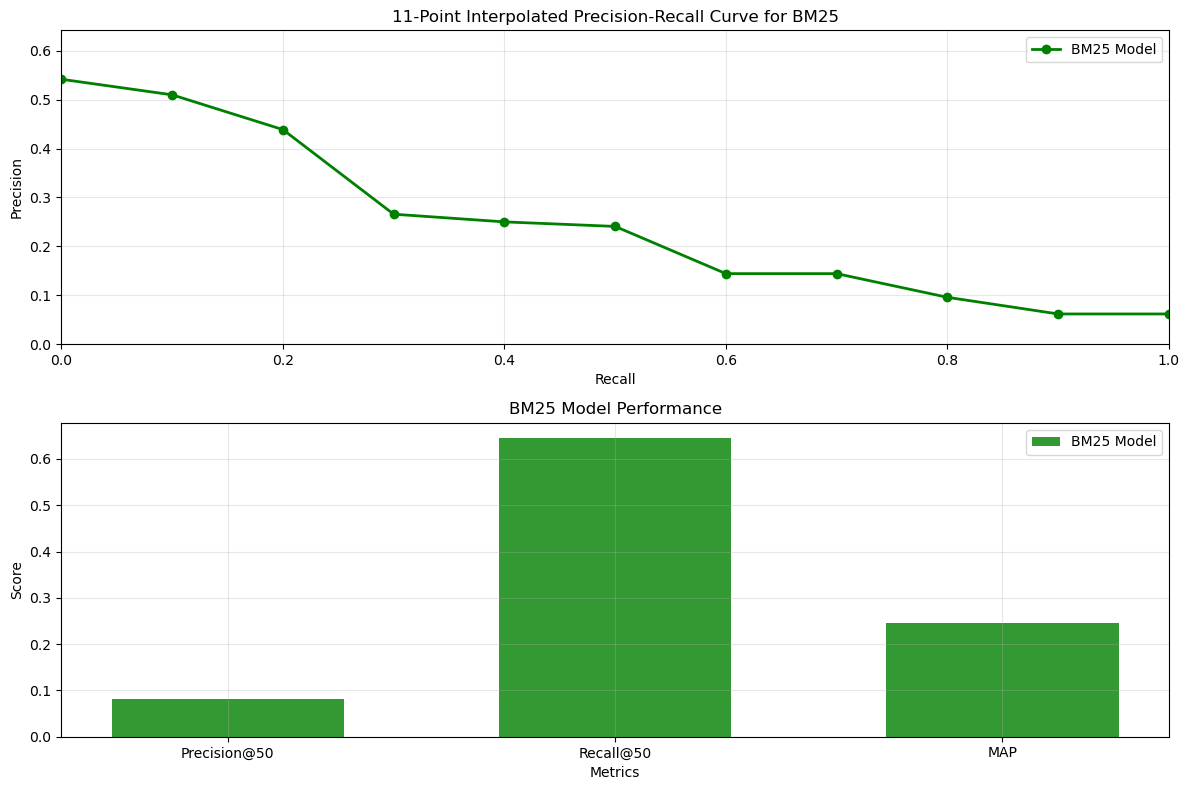


11-Point Interpolated Precision Values:
Recall | BM25 Model
-------|----------
   0.0 |   0.5416
   0.1 |   0.5098
   0.2 |   0.4387
   0.3 |   0.2658
   0.4 |   0.2501
   0.5 |   0.2408
   0.6 |   0.1443
   0.7 |   0.1443
   0.8 |   0.0959
   0.9 |   0.0619
   1.0 |   0.0619

EVALUATION COMPLETED


In [8]:
# Evaluation function
def evaluate_bm25_model(model, queries, qrels, model_name, top_k=50):
    """
    Evaluate BM25 model using precision, recall, and MAP
    """
    precisions_at_k = []
    recalls_at_k = []
    average_precisions = []
    all_interpolated_points = []
    
    print(f"\nEvaluating {model_name}...")
    
    for query_id, query_text in queries.items():
        if query_id not in qrels:
            continue
            
        relevant_docs = qrels[query_id]
        if not relevant_docs:
            continue
            
        # Get search results
        results = model.search(query_text, top_k=top_k)
        retrieved_docs = [r['doc_id'] for r in results]
        
        # Calculate metrics
        precision, recall = calculate_precision_recall(relevant_docs, retrieved_docs, k=top_k)
        ap = calculate_average_precision(relevant_docs, retrieved_docs)
        
        precisions_at_k.append(precision)
        recalls_at_k.append(recall)
        average_precisions.append(ap)
        
        # Calculate precision-recall curve for interpolation
        pr_pairs = []
        for i in range(1, min(len(retrieved_docs), 20) + 1):  # First 20 results
            p, r = calculate_precision_recall(relevant_docs, retrieved_docs, k=i)
            pr_pairs.append((p, r))
        
        interpolated = interpolate_precision_recall(pr_pairs)
        all_interpolated_points.append(interpolated)
    
    # Calculate overall metrics
    avg_precision = np.mean(precisions_at_k)
    avg_recall = np.mean(recalls_at_k)
    map_score = np.mean(average_precisions)
    
    # Calculate 11-point interpolated precision
    if all_interpolated_points:
        recall_levels = np.arange(0.0, 1.1, 0.1)
        mean_interpolated_precisions = []
        
        for i, recall_level in enumerate(recall_levels):
            precisions_at_level = [points[i][1] for points in all_interpolated_points]
            mean_interpolated_precisions.append(np.mean(precisions_at_level))
    else:
        mean_interpolated_precisions = [0.0] * 11
    
    return {
        'precision': avg_precision,
        'recall': avg_recall,
        'map': map_score,
        'interpolated_precisions': mean_interpolated_precisions,
        'num_queries': len(average_precisions)
    }

# Select a subset of queries for evaluation (first 20 queries with relevance judgments)
eval_queries = {}
eval_count = 0
for query_id in sorted(qrels.keys()):
    if eval_count >= 20:
        break
    if query_id in queries and len(qrels[query_id]) > 0:
        eval_queries[query_id] = queries[query_id]
        eval_count += 1

print(f"Evaluating on {len(eval_queries)} queries with relevance judgments")
print("Sample evaluation queries:")
for i, (qid, qtext) in enumerate(list(eval_queries.items())[:3]):
    print(f"  Query {qid}: {qtext[:60]}...")
    print(f"    Relevant docs: {len(qrels[qid])}")

# Evaluate BM25 model
bm25_results = evaluate_bm25_model(bm25_search, eval_queries, qrels, "BM25 Model")

# Display results
print("\n" + "="*60)
print("BM25 EVALUATION RESULTS")
print("="*60)

print(f"\nBM25 Model Results:")
print(f"  Average Precision@50: {bm25_results['precision']:.4f}")
print(f"  Average Recall@50:    {bm25_results['recall']:.4f}")
print(f"  MAP:                  {bm25_results['map']:.4f}")
print(f"  Number of queries:    {bm25_results['num_queries']}")




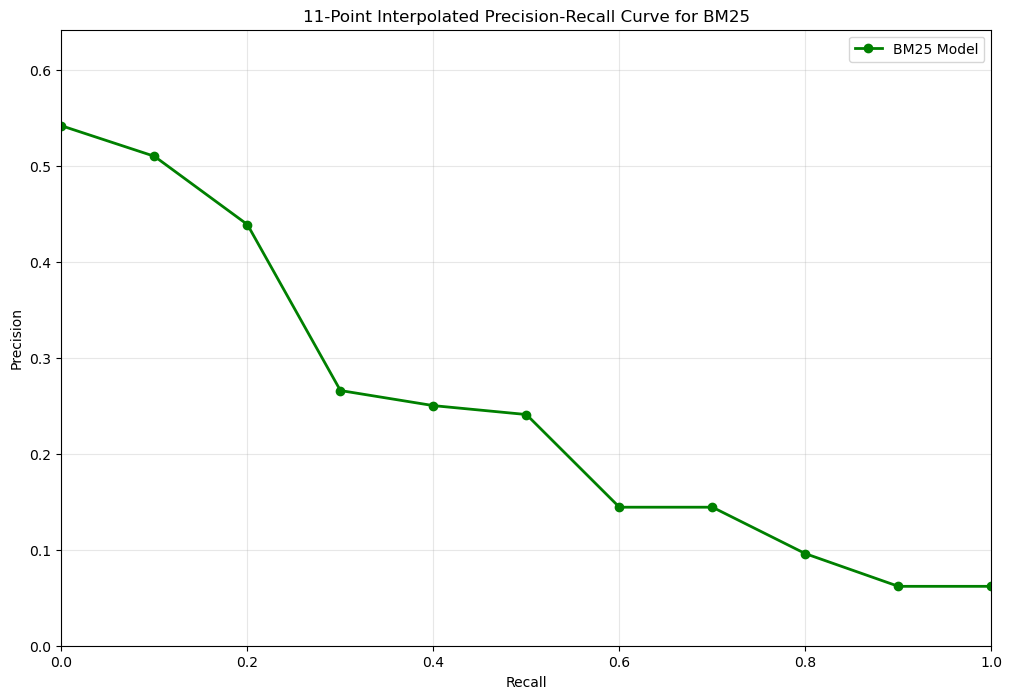

In [26]:
# Plot 11-point interpolated precision-recall curves
plt.figure(figsize=(12, 8))
recall_levels = np.arange(0.0, 1.1, 0.1)


plt.plot(recall_levels, bm25_results['interpolated_precisions'], 'go-', label='BM25 Model', linewidth=2, markersize=6)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('11-Point Interpolated Precision-Recall Curve for BM25')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)

# Determine y-axis limit
max_precision = max(bm25_results['interpolated_precisions'])
if max_precision > 0:
    plt.ylim(0, max_precision + 0.1)
else:
    plt.ylim(0, 1)



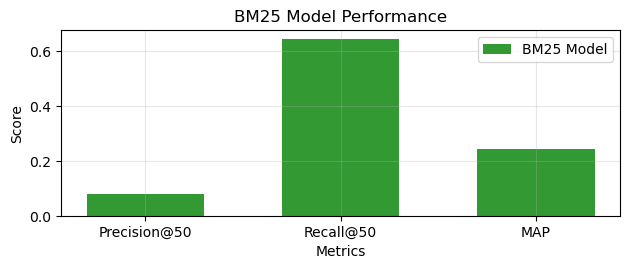


11-Point Interpolated Precision Values:
Recall | BM25 Model
-------|----------
   0.0 |   0.5416
   0.1 |   0.5098
   0.2 |   0.4387
   0.3 |   0.2658
   0.4 |   0.2501
   0.5 |   0.2408
   0.6 |   0.1443
   0.7 |   0.1443
   0.8 |   0.0959
   0.9 |   0.0619
   1.0 |   0.0619

EVALUATION COMPLETED


In [24]:
# Plot metrics bar chart
plt.subplot(2, 1, 2)
metrics = ['Precision@50', 'Recall@50', 'MAP']
bm25_values = [bm25_results['precision'], bm25_results['recall'], bm25_results['map']]

x = np.arange(len(metrics))
width = 0.6

plt.bar(x, bm25_values, width, label='BM25 Model', alpha=0.8, color='green')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('BM25 Model Performance')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n11-Point Interpolated Precision Values:")
print("Recall | BM25 Model")
print("-------|----------")
for i, recall in enumerate(recall_levels):
    bm25_prec = bm25_results['interpolated_precisions'][i]
    print(f"{recall:6.1f} | {bm25_prec:8.4f}")

print("\n" + "="*60)
print("EVALUATION COMPLETED")
print("="*60)

In [25]:
# Detailed evaluation example with specific queries
print("=== DETAILED EVALUATION EXAMPLE ===")
print()

# Take first few queries with relevance judgments for detailed analysis
sample_queries = dict(list(eval_queries.items())[:3])

for query_id, query_text in sample_queries.items():
    print(f"Query {query_id}: {query_text}")
    print(f"Relevant documents ({len(qrels[query_id])}): {qrels[query_id][:10]}")
    
    # Get results from BM25 model
    bm25_results_sample = bm25_search.search(query_text, top_k=10)
    
    print("\nTop 5 BM25 Results:")
    for i, result in enumerate(bm25_results_sample[:5]):
        doc_id = result['doc_id']
        similarity = result['similarity']
        is_relevant = "‚úì" if doc_id in qrels[query_id] else "‚úó"
        print(f"  {i+1}. Doc {doc_id} (score: {similarity:.4f}) {is_relevant}")
    
    # Calculate precision@5 for this query
    bm25_relevant_at_5 = sum(1 for r in bm25_results_sample[:5] if r['doc_id'] in qrels[query_id])
    
    print(f"\nPrecision@5:")
    print(f"  BM25 Model: {bm25_relevant_at_5}/5 = {bm25_relevant_at_5/5:.3f}")
    print("-" * 80)

print("\n=== BM25 MODEL SUMMARY ===")
print(f"Evaluation completed on {len(eval_queries)} queries")
print(f"BM25 Model Performance:")
print(f"  ‚Ä¢ Precision@50: {bm25_results['precision']:.4f}")
print(f"  ‚Ä¢ Recall@50: {bm25_results['recall']:.4f}")
print(f"  ‚Ä¢ MAP: {bm25_results['map']:.4f}")

print(f"\nBM25 Parameters used:")
print(f"  ‚Ä¢ k1 (term frequency saturation): {bm25_model.k1}")
print(f"  ‚Ä¢ b (length normalization): {bm25_model.b}")

print(f"\nDataset Statistics:")
print(f"  ‚Ä¢ Total documents: {len(documents)}")
print(f"  ‚Ä¢ Total queries: {len(queries)}")
print(f"  ‚Ä¢ Queries with relevance judgments: {len(qrels)}")
print(f"  ‚Ä¢ Vocabulary size: {len(bm25_model.idf)}")
print(f"  ‚Ä¢ Average document length: {bm25_model.avgdl:.2f} terms")

print(f"\nüéØ BM25 model evaluation completed successfully!")


=== DETAILED EVALUATION EXAMPLE ===

Query 1: what similarity laws must be obeyed when constructing aeroelastic models
of heated high speed aircraft .
Relevant documents (28): ['184', '29', '31', '12', '51', '102', '13', '14', '15', '57']


AttributeError: 'dict' object has no attribute 'get_scores'